# Ofset free MPC using matric C

In [35]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load matrices, model, scalers and load process

In [36]:
matrix_C = False

# Load matrices A, B, and C 
A = np.load('./data/A_C_' + str(matrix_C) + '.npy')
B = np.load('./data/B_C_' + str(matrix_C) + '.npy')
C = np.load('./data/C_C_' + str(matrix_C) + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [37]:
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))


Close to block diagonal? True
Backtransformation equals original A? True


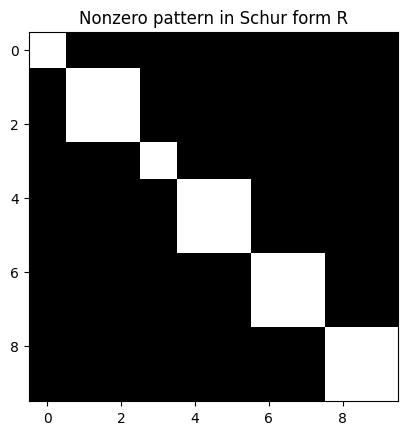

In [38]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(A_transformed) > 1e-6, cmap='gray')
plt.title("Nonzero pattern in Schur form R")
plt.show()

In [39]:
A = A_block
B = inv(T_real) @ B
C = C @ T_real


In [40]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [41]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

# no loss function because only using the model not training it
loss = PenaltyLoss([], constraints=[])

problem = Problem(nodes, loss)

problem.load_state_dict(torch.load('data/model_C_' + str(matrix_C) + '.pth'),strict=False)



<All keys matched successfully>

In [42]:
# load scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [43]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

In [44]:
# probably yes
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1)

## Optimal control problem

Observer - Kalman filter

In [45]:
loaded_setup = joblib.load("sim_setup.pkl")

In [46]:
y_start = loaded_setup['y_start']

y_setpoint = loaded_setup['reference'][:,0]

u_previous = loaded_setup['u_previous']

z_est_ = np.hstack((get_x(y_start).T, np.zeros((1,nd))))
z_est_[:,:10] = (inv(T_real)@z_est_[:,:10].T).T
P0 = loaded_setup['P0']

# Noise covariances
Q = loaded_setup['Q']  # process noise
R = loaded_setup['R']  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

C_ = np.hstack([
    C, np.eye(nd)
])

KF = helper.KF(A_,B_,C_,z_est_,P0, Q, R)



Target calculation

In [47]:
N = loaded_setup['N']
Qy = loaded_setup['Qy']
Qu = loaded_setup['Qu']
Qz = C.T@Qy@C
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
d0 = cp.Parameter(ny)
d0.value = np.zeros(ny)
u_prev = cp.Parameter(nu)

y_sp = cp.Parameter(ny)
y_sp.value = y_setpoint
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
#y = cp.Variable((ny, N+1))
#delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N)) 
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)


In [48]:
# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[0.50000002 0.49999999]]


MPC problem formulation


In [49]:
z0.value = z_est_[0,0:nz]
u_prev.value = u_previous

In [50]:
z_est_

array([[ 0.49124608,  0.0722996 , -0.0462825 , -0.31750625,  0.25787594,
         0.20582121, -0.24140712, -1.04935857, -0.11825113,  0.37257962,
         0.        ,  0.        ]])

In [51]:
# Constraints and cost
constraints = [z[:, 0] == z0]
cost = 0

for k in range(N):
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= C @ z[:, k] + F @ d0, C @ z[:, k] + F @ d0 <= y_max
    ]
    if k == 0:
        cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(u[:, 0] - u_prev, Qu)
    else:
        cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(u[:, k] - u[:, k-1], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [52]:
# sanity check and problem formulation
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[-0.72493417 -0.18052097]
optimal


In [53]:
import time

sim_time = 150
optimal = 0
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))
y_sp.value = scaler.transform(np.array([[0.5,0.5]]))[0]

total_time_target = 0
total_time_mpc = 0

start_time_target = time.time()
target_estimation.solve(solver=cp.GUROBI)
end_time_target = time.time()
print(f"Target estimation solve time: {end_time_target - start_time_target:.4f} seconds")
total_time_target += end_time_target - start_time_target
z_ref.value = z_s.value

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]

for k in range(sim_time):
    if k == 50:
        y_sp.value = loaded_setup['reference'][:,100]
    # solve MPC
    start_time_mpc = time.time()
    mpc.solve(solver=cp.GUROBI)
    end_time_mpc = time.time()
    print(f"MPC solve time at step {k}: {end_time_mpc - start_time_mpc:.4f} seconds")
    total_time_mpc += end_time_mpc - start_time_mpc
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = KF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    start_time_target = time.time()
    target_estimation.solve(solver=cp.GUROBI)
    end_time_target = time.time()
    print(f"Target estimation solve time at step {k}: {end_time_target - start_time_target:.4f} seconds")
    total_time_target += end_time_target - start_time_target
    ys_sim[:, k+1] = y_s.value
    zs_sim[:, k+1] = z_s.value
    z_ref.value = z_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    if mpc.status == "optimal":
        optimal += 1

print(f"Total time spent in target estimation: {total_time_target:.4f} seconds")
print(f"Total time spent in MPC solve: {total_time_mpc:.4f} seconds")

Target estimation solve time: 0.0016 seconds
MPC solve time at step 0: 0.0111 seconds
Target estimation solve time at step 0: 0.0021 seconds
optimal
MPC solve time at step 1: 0.0096 seconds
Target estimation solve time at step 1: 0.0015 seconds
optimal
MPC solve time at step 2: 0.0092 seconds
Target estimation solve time at step 2: 0.0018 seconds
optimal
MPC solve time at step 3: 0.0097 seconds
Target estimation solve time at step 3: 0.0014 seconds
optimal
MPC solve time at step 4: 0.0092 seconds
Target estimation solve time at step 4: 0.0023 seconds
optimal
MPC solve time at step 5: 0.0095 seconds
Target estimation solve time at step 5: 0.0014 seconds
optimal
MPC solve time at step 6: 0.0094 seconds
Target estimation solve time at step 6: 0.0015 seconds
optimal
MPC solve time at step 7: 0.0096 seconds
Target estimation solve time at step 7: 0.0014 seconds
optimal
MPC solve time at step 8: 0.0093 seconds
Target estimation solve time at step 8: 0.0017 seconds
optimal
MPC solve time at s

In [54]:
optimal

150

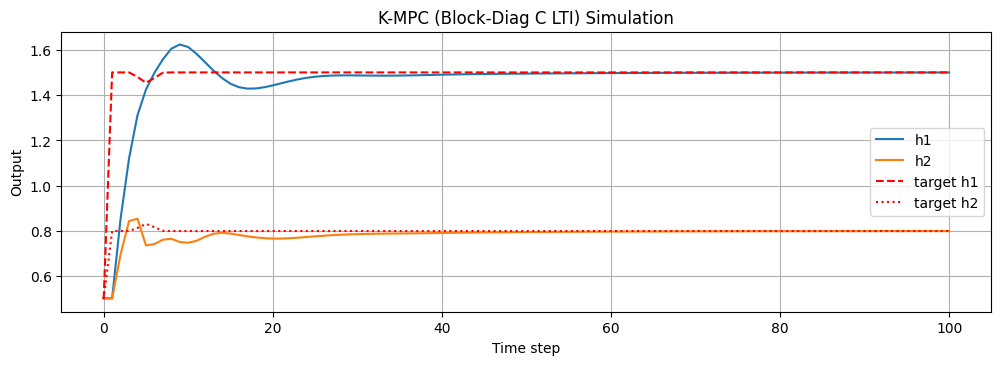

In [55]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0,50:], label='h1')
plt.plot(y_sim_descaled[1,50:], label='h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0,50:], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1,50:], color='red', linestyle=':', label='target h2')
plt.title('K-MPC (Block-Diag C LTI) Simulation')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [56]:
y_setpoint = loaded_setup['reference'][:,100]

In [57]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 92


In [58]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 94


In [59]:
from sklearn.metrics import mean_squared_error

# Descales ys_sim
ys_sim_descaled = scaler.inverse_transform(ys_sim.T).T

# Compute MSE for each output
mse_h1 = mean_squared_error(ys_sim_descaled[0], y_sim_descaled[0])
mse_h2 = mean_squared_error(ys_sim_descaled[1], y_sim_descaled[1])

print(f"MSE for h1: {mse_h1}")
print(f"MSE for h2: {mse_h2}")

MSE for h1: 0.011068251109386197
MSE for h2: 0.0009564785624027114


In [60]:
from numpy import trapz

# Compute ISE for each output
ise_h1 = trapz((ys_sim_descaled[0] - y_sim_descaled[0])**2)
ise_h2 = trapz((ys_sim_descaled[1] - y_sim_descaled[1])**2)

print(f"ISE for h1: {ise_h1}")
print(f"ISE for h2: {ise_h2}")

ISE for h1: 1.6713058772392393
ISE for h2: 0.1444282317644863


In [61]:
from numpy import trapz

# Compute ISE for y_sim starting from step 50
ise_h1 = trapz((y_sim[0, 50:] - y_setpoint[0])**2)
ise_h2 = trapz((y_sim[1, 50:] - y_setpoint[1])**2)

print(f"ISE for h1 (from step 50): {ise_h1}")
print(f"ISE for h2 (from step 50): {ise_h2}")


ISE for h1 (from step 50): 2.775986220819195
ISE for h2 (from step 50): 0.3473096480293807


In [62]:

# Compute the closed-loop value of the objective function

objective_value = 0
for k in range(50,sim_time):
    y_diff = y_sim[:, k] - y_setpoint
    u_diff = u_sim[:, k] - u_sim[:, k-1]
    objective_value += y_diff.T @ Qy @ y_diff 
    objective_value += u_diff.T @ Qu @ u_diff
    #print(f"Objective value at step {k}: {objective_value}")

print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 20.288842620367593


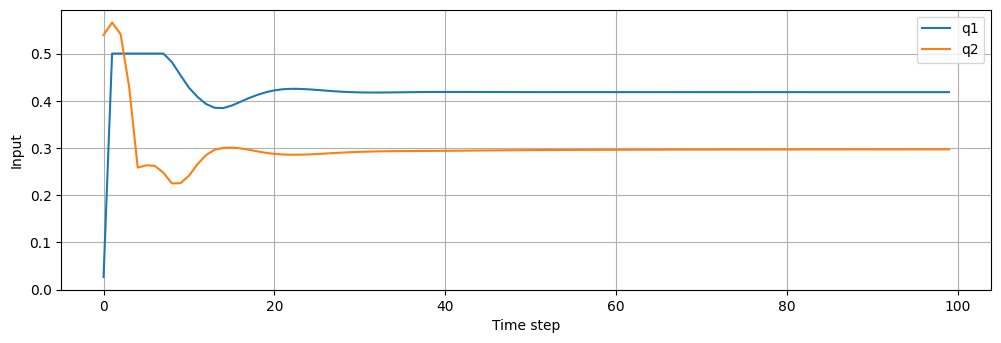

In [63]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0,50:], label='q1')
plt.plot(u_sim_descaled[1,50:], label='q2')
plt.xlabel('Time step')
plt.ylabel('Input')
plt.legend()
plt.grid(True) 

In [64]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[44.08300856 56.09514358]


/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_46735/3350633214.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


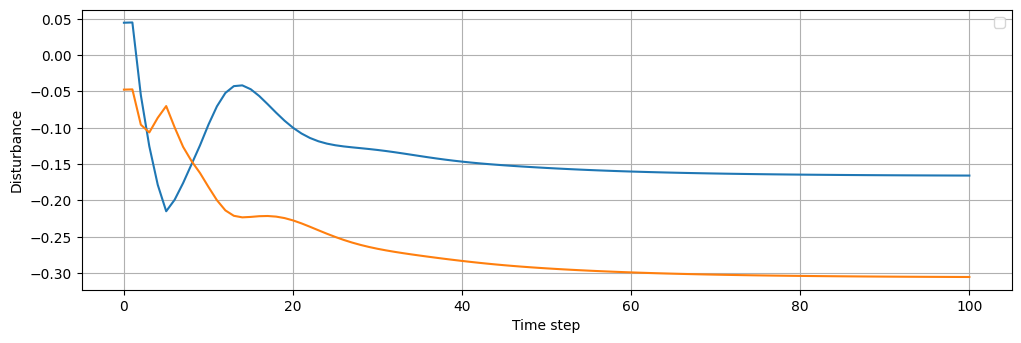

In [65]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[nz:,50:].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

In [66]:
scalerU.scale_

array([0.14911892, 0.29077111])

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_46735/4249820153.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


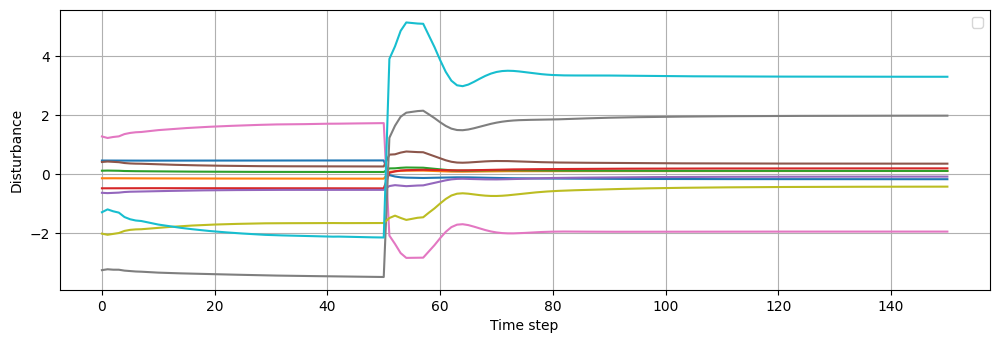

In [67]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(zs_sim[:nz].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_46735/2974051967.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


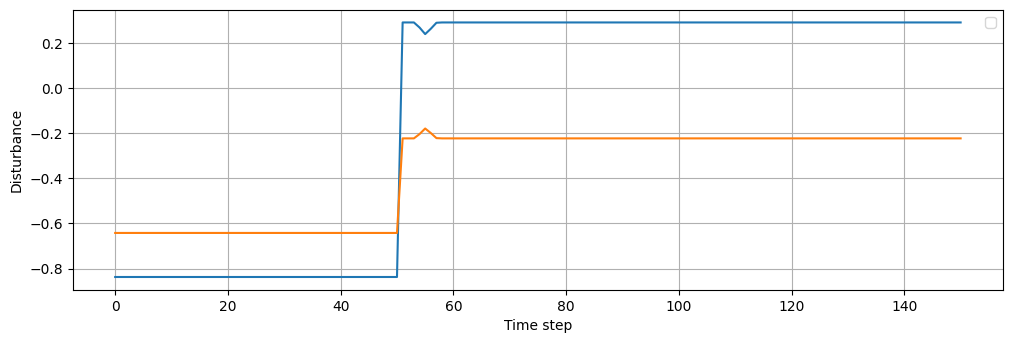

In [68]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ys_sim.T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)